In [1]:
import gym

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs = env.reset()
obs

(array([ 0.01348377, -0.03901596, -0.03950879,  0.04829282], dtype=float32),
 {})

In [18]:
img = env.render()
img.shape

(400, 600, 3)

In [19]:
env.action_space

Discrete(2)

In [21]:
action = 1
obs, reward, terminated, truncated, info = env.step(action)
obs

array([-0.01702628,  0.43062097,  0.01802544, -0.5462712 ], dtype=float32)

In [22]:
reward

1.0

In [23]:
print(terminated)
print(truncated)

False
False


In [24]:
info

{}

In [25]:
from tqdm import tqdm
# 기본 policy: 막대가 오른쪽으로 기울어지면 오른쪽으로 움직이고, 그렇지 않으면 왼쪽으로 움직인다. 
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

env = gym.make("CartPole-v1", render_mode="human")
totals = []
for _ in tqdm(range(500)):
    episode_rewards = 0
    obs = env.reset()
    obs = obs[0]
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_rewards += reward
        if terminated or truncated:
            obs, info = env.reset()
            break
    totals.append(episode_rewards)

env.close()

100%|██████████| 500/500 [07:35<00:00,  1.10it/s]


In [26]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.32, 8.778473671430588, 24.0, 68.0)

## 18.4 신경망 policy

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gym
from tqdm import tqdm

n_inputs = 4 

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

## 18.6 policy gradient

In [2]:
env = gym.make("CartPole-v1", render_mode="human")

In [3]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, terminated, grads

In [11]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        obs = obs[0]
        for step in range(n_max_steps):
            obs, reward, terminated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if step >= n_max_steps - 1:
                print("step done")
            if terminated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [5]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]


In [6]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [7]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [8]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [12]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [13]:
for iteration in tqdm(range(n_iterations)):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

100%|██████████| 150/150 [15:05<00:00,  6.04s/it]


## 18.7

In [14]:
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0],            None, [0.0, 0.0, 1.0]],
    [           None, [0.8, 0.1, 0.1],            None]
]
rewards = [
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [38]:
Q_values = np.full((3, 3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state, action] = 0.0

print(Q_values)

[[  0.   0.   0.]
 [  0. -inf   0.]
 [-inf   0. -inf]]


In [39]:
gamma = 0.90

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) 
                                     for sp in range(3)])

In [40]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [33]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

## 18.9 Q-learning

In [34]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [35]:
Q_values = np.full((3, 3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state, action] = 0.0

print(Q_values)

[[  0.   0.   0.]
 [  0. -inf   0.]
 [-inf   0. -inf]]


In [36]:
alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇠
gamma = 0.90  # 할인 계수
state = 0     # 초기 상태


for iteration in range(1000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

In [37]:
Q_values

array([[ 13.34298101,  10.48536483,   8.611916  ],
       [  0.        ,         -inf, -19.884584  ],
       [        -inf,  38.62674598,         -inf]])

## 3.10 deep Q-learnning 구현

In [1]:
import gym
import keras
import numpy as np 
from collections import deque
import tensorflow as tf
from tqdm import tqdm

In [2]:
env = gym.make("CartPole-v0", render_mode="human")
input_shape = [4]
n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

d:\CondaEnvs\RL\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

In [4]:
replay_buffer = deque(maxlen=2000)

In [5]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [6]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, terminated))
    return next_state, reward, terminated, truncated, info

In [7]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1-dones) * discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [11]:
steps_per_episode = []
reward_per_episode = []
for episode in tqdm(range(400)):
    obs = env.reset()
    obs = obs[0]
    rewards = 0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, terminated, truncated, info = play_one_step(env, obs, epsilon)
        rewards += reward
        if step >= 199:
            print('count: 200 done!')
        if terminated or truncated:
            break
    steps_per_episode.append(step)
    reward_per_episode.append(rewards)
    if episode > 50:
        training_step(batch_size)
    
env.close()

 78%|███████▊  | 312/400 [07:31<07:44,  5.28s/it]

count: 200 done!


 84%|████████▍ | 335/400 [09:03<05:52,  5.42s/it]

count: 200 done!


 84%|████████▍ | 337/400 [09:16<06:17,  5.99s/it]

count: 200 done!


 85%|████████▌ | 341/400 [09:38<05:48,  5.91s/it]

count: 200 done!


 87%|████████▋ | 348/400 [10:12<04:25,  5.10s/it]

count: 200 done!


 90%|█████████ | 362/400 [11:31<04:06,  6.48s/it]

count: 200 done!


 94%|█████████▍| 378/400 [12:38<01:58,  5.37s/it]

count: 200 done!


 95%|█████████▌| 380/400 [12:49<01:53,  5.68s/it]

count: 200 done!


 96%|█████████▌| 382/400 [13:04<01:58,  6.58s/it]

count: 200 done!


 96%|█████████▋| 385/400 [13:22<01:37,  6.48s/it]

count: 200 done!


 96%|█████████▋| 386/400 [13:30<01:36,  6.90s/it]

count: 200 done!


100%|██████████| 400/400 [14:47<00:00,  2.22s/it]


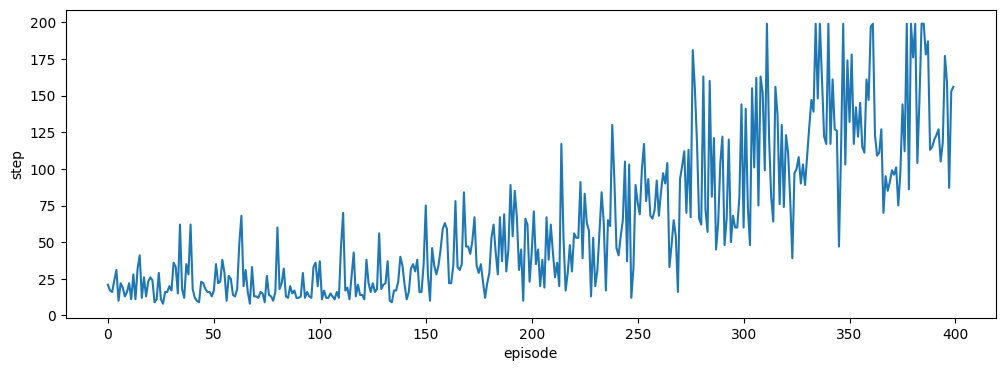

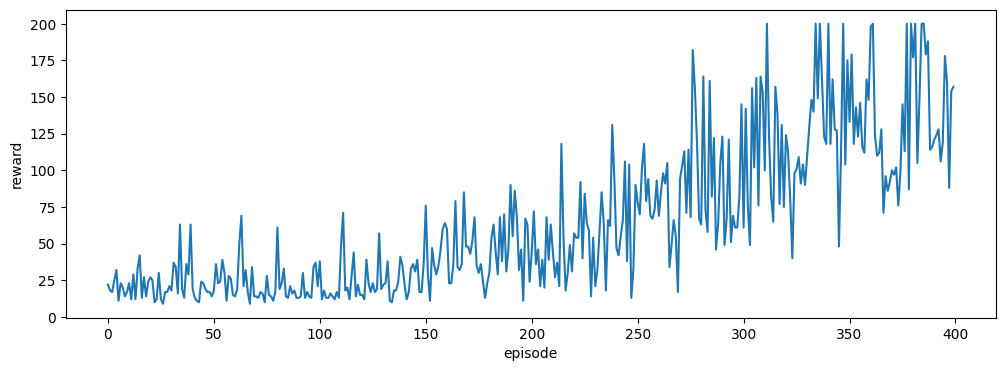

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,  4))
plt.plot(steps_per_episode)
plt.xlabel('episode')
plt.ylabel('step')
plt.show()

plt.figure(figsize=(12,  4))
plt.plot(reward_per_episode)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

## 18.11 더블 DQN

In [ ]:
h

In [ ]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target)
    # max_next_Q_values = np.max(next_Q_values, axis=1)
    # target_Q_values = (rewards + (1-dones) * discount_factor * max_next_Q_values)
    # target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## 18.12 TF-Agents library

In [39]:
from tf_agents.environments import suite_gym

env = suite_gym.load('Breakout-v4', render_kwargs="human")
env

In [40]:
env.gym

<TimeLimit<OrderEnforcing<AtariEnv<Breakout-v4>>>>

In [41]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})

In [42]:
env.step(1)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1)})

In [43]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [44]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [45]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [46]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [47]:
# 환경 래퍼와 아타리 전처리
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)

In [48]:
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    'Breakout-v4',
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)

In [49]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environmnet_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environmnet_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4],
)

In [16]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

In [17]:
# 심층 Q 네트워크 만들기
import keras
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 225.
)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_parmas = [512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_parmas
)

In [18]:
# DQN 에이전트 만들기
from tf_agents.agents.dqn.dqn_agent import DqnAgent
import tensorflow as tf

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01
)
agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction='none'),
    gamma=0.99,
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)
agent.initialize()

In [19]:
# 재생 버퍼와 옵저버 만들기
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000
)

In [20]:
replay_buffer_observer = replay_buffer.add_batch

In [25]:
from typing import Any


class ShowPrograss:
    def __init__(self, total) -> None:
        self.counter = 0
        self.total = total

    def __call__(self, trajectory, *args: Any, **kwds: Any) -> Any:
        if not trajectory.is_boundary():
            self.counter += 1
        
        if self.counter % 100 == 0:
            print(f"\r{self.counter}/{self.total}", end="")

In [21]:
# 훈련 측정 지표 만들기
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [22]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [24]:
# 수집 드라이버 만들기
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)


In [26]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowPrograss(20000)],
    num_steps=20000
)
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [31]:
# 데이터셋 만들기
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [32]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [33]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]])

In [34]:
from tf_agents.trajectories.trajectory import to_transition
time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [35]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3
).prefetch(3)

In [36]:
# 훈련 반복 만들기
from tf_agents.utils.common import function
collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [37]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print(f"\r{iteration} loss: {train_loss.loss.numpy():.5f}", end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [50]:
train_agent(10000000)

INFO:absl: 
		 NumberOfEpisodes = 17
		 EnvironmentSteps = 3168
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 193.60000610351562


997 loss: 0.00779

INFO:absl: 
		 NumberOfEpisodes = 38
		 EnvironmentSteps = 7168
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 183.1999969482422


1998 loss: 0.00787

INFO:absl: 
		 NumberOfEpisodes = 61
		 EnvironmentSteps = 11168
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 181.3000030517578


2999 loss: 0.00026

INFO:absl: 
		 NumberOfEpisodes = 80
		 EnvironmentSteps = 15168
		 AverageReturn = 1.0
		 AverageEpisodeLength = 175.60000610351562


3996 loss: 0.00003

INFO:absl: 
		 NumberOfEpisodes = 101
		 EnvironmentSteps = 19168
		 AverageReturn = 1.5
		 AverageEpisodeLength = 199.89999389648438


4999 loss: 0.00008

INFO:absl: 
		 NumberOfEpisodes = 123
		 EnvironmentSteps = 23168
		 AverageReturn = 1.0
		 AverageEpisodeLength = 175.3000030517578


5611 loss: 0.00761

KeyboardInterrupt: 